# Decomposição LU (ou Fatoração LU)

<i>Créditos: grande parte deste notebook foi traduzido de https://github.com/fastai/numerical-linear-algebra</i>

A <b>Eliminação de Gauss</b> transforma um sistema linear em um triangular superior aplicando uma série de transformações lineares à sua esquerda. Cada transformação pode ser representada por uma pré-multiplicação por uma matriz triangular inferior $L_i$, para $i=1,\ldots,n-1$.
$$
L_{n-1} L_{n-2} \ldots L_{1} A = U
$$

O produto $L = (L_{n-1}\ldots L_{1})^{-1} = L_{1}^{-1} \ldots L_{n-1}^{-1}$ é uma matriz triangular inferior unitária (isto é, todos elementos da diagonal são iguais a 1).

In [22]:
import numpy as np
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.eye(n)
    for k in range(n-1):
        for j in range(k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:n] -= L[j,k] * U[k,k:n]
    return L, U

In [23]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [24]:
L, U = LU(A)

In [25]:
np.allclose(A, L.dot(U))

True

A fatoração LU é útil!

Resolver Ax = b passa a ser LUx = b:
1. encontre A = LU
2. resolva Ly = b
3. resolva Ux = y

**Tempo**

Número de operações da Eliminação de Gauss: $2\cdot\frac{1}{3} n^3$

**Memória**

Na implementação acima nós criamos duas matrizes $L$ e $U$. Porém, podemos armazenar os valores de $L$ e $U$ na nossa matriz $A$ (sobrescrevendo a matriz original). Como a diagonal de $L$ é toda composta por $1$s, não é necessário armazená-la.  Realizar fatorações ou cálculos **in-place** é uma técnica comum em álgebra linear numérica para economizar memória.  Nota: isto não deve ser feito se você for precisar da matriz $A$ futuramente. Uma das questões da lista de exercícios é reescrever o método LU para ser executado in-place.

Considere a matriz $$ A = \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} $$

In [26]:
A = np.array([[1e-20, 1], [1,1]])

In [28]:
?np.array

Calcule manualmente os valores de $L$ e de $U$.

In [29]:
L1 = np.array([[1,0],[1e20,1]],dtype=np.float64)
U1 = np.array([[1e-20,1],[0,1-1e20]],dtype=np.float64)

In [30]:
np.set_printoptions(suppress=True)
L2, U2 = LU(A)
L2, U2

(array([[  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+20,   1.00000000e+00]]),
 array([[  1.00000000e-20,   1.00000000e+00],
        [  0.00000000e+00,  -1.00000000e+20]]))

In [31]:
np.allclose(L1, L2)

True

In [32]:
np.allclose(U1, U2)

True

In [35]:
np.allclose(A, L2.dot(U2))

False

Esta é a motivação para a Fatoração $LU$ **com pivotação**.

Este exemplo também mostra que a fatoração LU não é *retro-estável*. (spoiler alert: mesmo com pivotação parcial, LU é "explosivamente instável" para certas matrizes, embora estável na prática).

#### Backward Stability (retro-estabilidade?)

Existe o conceito de estabilidade, mas ele é mais complicado e não será útil agora (ver Trefethen, p. 104).

Retro-estabilidade é mais **forte** e **simples** que estabilidade. 

Um algoritmo $\hat{f}$ para um problema $f$ é **retro-estável** se para cada $x$,
$$ \hat{f}(x) = f(y) $$

para algum $y$ tal que
$$ \frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine}) $$

**Um algoritmo retro-estável retorna exatamente a resposta correta para a pergunta quase correta** (Trefethen, pg 104)

Traduzindo:

- pergunta correta: $x$ (no caso, A)
- pergunta quase correta: $y$ (no caso, $A'=L_2 U_2$ não satisfaz $\frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine})$)
- resposta correta: $f$
- resposta correta para a pergunta quase correta: $f(y)$

### LU factorization with Partial Pivoting

Considere agora a matriz $$ \hat{A} = \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

In [36]:
A = np.array([[1,1], [1e-20, 1]])

Use a eliminação de Gauss para calcular as matrizes $L$ e $U$.

In [37]:
L1 = np.array([[1,0],[1e-20,1]])
U1 = np.array([[1,1],[0,1-1e-20]])

In [38]:
L, U = LU(A)

In [39]:
np.allclose(A, L.dot(U))

True

**Ideia**: Podemos trocar a ordem das linhas para obter respostas mais estáveis! Isto é equivalente a pré-multiplicar por uma matriz de permutação $P$. Por exemplo,

$$\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} =  \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

$$ PA = \hat{A} $$

Na prática, estamos aplicando a Eliminação de Gauss a $PA$.

**Pivotação parcial**: Na eliminação da coluna $k$, escolha o maior valor em módulo da coluna $k$, e permute aquela linha com a linha $k$.

#### Exercício

In [40]:
def swap(a,b):
    temp = np.copy(a)
    a[:] = b
    b[:] = temp

a=np.array([1,2,3])
b=np.array([3,2,1])
swap(a,b)
a,b

(array([3, 2, 1]), array([1, 2, 3]))

In [ ]:
#Exercício: reescreva a fatoração LU para usar pivotação

**Pivotação parcial** permuta as linhas. É uma prática tão universal que isto é normalmente o que é conhecido como *Fatoração LU*.

**Pivotação completa** permuta linhas e colunas. Pivotação completa consome um tempo significativo e raramente é utilizada na prática.

#### Exemplo
Considere o sistema de equações:

$$ \begin{bmatrix} 1 & 0 & 0  & 0 & 0 & 1 \\ -1 & 1 & 0  & 0 & 0 & 1 \\ -1 & -1 & 1  & 0 & 0 & 1 \\ -1 & -1 & -1  & 1 & 0 & 1  \\  -1 & -1 & -1  & -1 & 1 & 1 \\ -1 & -1 & -1  & -1 & -1 & 1 \end{bmatrix} \mathbf{x} = \begin{bmatrix} 1 \\ 1 \\ 1  \\ 1 \\ 2 \\ 1 \end{bmatrix} $$

In [41]:
def make_matrix(n):
    A = np.eye(n)
    for i in range(n):
        A[i,-1] = 1
        for j in range(i):
            A[i,j] = -1
    return A 

In [42]:
def make_vector(n):
    b = np.ones(n)
    b[-2] = 2
    return b

In [43]:
make_vector(7)

array([ 1.,  1.,  1.,  1.,  1.,  2.,  1.])

#### Exercício

Vamos utilizar a Eliminação de Gauss no sistema $5 \times 5$.

Scipy também tem esta funcionalidade.  Vamos olhar para a solução das 5 últimas equações com $n=10,\,20,\,30,\,40,\,50,\,60$.

In [19]:
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
?scipy.linalg.lu_solve

In [45]:
zip(range(10, 70, 10), ['--', ':', '-', '-.', '--', ':'])

[(10, '--'), (20, ':'), (30, '-'), (40, '-.'), (50, '--'), (60, ':')]

[-0.00195312 -0.00390625 -0.0078125  -0.015625   -0.03125    -0.0625     -0.125
 -0.25        0.5         1.00195312]
[ -1.90734863e-06  -3.81469727e-06  -7.62939453e-06  -1.52587891e-05
  -3.05175781e-05  -6.10351562e-05  -1.22070312e-04  -2.44140625e-04
  -4.88281250e-04  -9.76562500e-04  -1.95312500e-03  -3.90625000e-03
  -7.81250000e-03  -1.56250000e-02  -3.12500000e-02  -6.25000000e-02
  -1.25000000e-01  -2.50000000e-01   5.00000000e-01   1.00000191e+00]
[ -1.86264515e-09  -3.72529030e-09  -7.45058060e-09  -1.49011612e-08
  -2.98023224e-08  -5.96046448e-08  -1.19209290e-07  -2.38418579e-07
  -4.76837158e-07  -9.53674316e-07  -1.90734863e-06  -3.81469727e-06
  -7.62939453e-06  -1.52587891e-05  -3.05175781e-05  -6.10351562e-05
  -1.22070312e-04  -2.44140625e-04  -4.88281250e-04  -9.76562500e-04
  -1.95312500e-03  -3.90625000e-03  -7.81250000e-03  -1.56250000e-02
  -3.12500000e-02  -6.25000000e-02  -1.25000000e-01  -2.50000000e-01
   5.00000000e-01   1.00000000e+00]
[ -1.81898940e-12

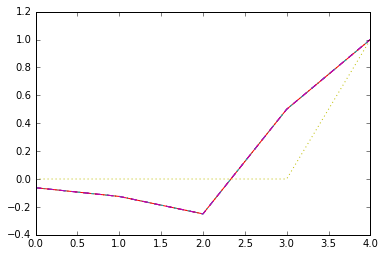

In [20]:
for n, ls in zip(range(10, 70, 10), ['--', ':', '-', '-.', '--', ':']):
    soln = scipy.linalg.lu_solve(scipy.linalg.lu_factor(make_matrix(n)), make_vector(n))
    plt.plot(soln[-5:], ls)
    print(soln)

O que está acontecendo quando $n=60$?

**Teorema**: Seja a fatoração $PA = LU$ de uma matriz A calculada pela Eliminação de Gauss com pivotação parcial.  As matrizes *calculadas* (por um computador com Aritmética de Ponto Flutuante) $\hat{P}$, $\hat{L}$, e $\hat{U}$ satisfazem

$$\hat{L}\hat{U} = \hat{P} A + \delta A, \quad \frac{\delta A}{A} = \mathcal{O}(\rho \varepsilon_{machine}), $$

onde $\rho$ é o *fator de crescimento*, 

$$\rho = \frac{max_{i,j} \lvert u_{ij} \rvert }{max_{i,j} \lvert a_{ij} \rvert }. $$

Para a nossa matriz acima, $\rho = 2^{n-1}$.

#### Instável na teoria, estável na prática

A estabilidade de maioria dos algoritmos numéricos (como QR) é bem direta. Este não é o caso da Eliminação de Gauss com pivotação parcial. Instabilidade na Eliminação de Gauss (com ou sem pivotação) acontece somente se $L$ e/ou $U$ são grandes em relação a norma de $A$.

Trefethen: "Despite examples like (22.4), Gaussian elimination with partial pivoting is utterly stable in practice... In fifty years of computing, no matrix problems that excite an explosive instability are known to have arisen under natural circumstances." [embora exemplos possam ser facilmente construídos]

Embora algumas matrizes causem instabilidade, elas correspondem a uma proporção extraordinariamente pequena de todas as matrizes. Assim, elas "nunca" acontecem na prática por razões estatísticas.  "Se você pegar um bilhão de matrizes aleatoriamente, você quase com certeza **não** irá encontrar uma para a qual a Eliminação de Gauss é instável."